<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/Untitled3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Formation deep learning

L'objet de ce TP est de présenter brievement les outils de deep learning Pytorch. Il comporte 3 parties

1.   Les briques de bases
2.   Le traitement d'ECG par convolution
3.   Les réseaux récurrents



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import torch.autograd.variable

##Les briques de bases

La brique de base de pytorch est l'objet Variable : il stocke en interne les opérations effectués sur un tenseur, de sorte à pouvoir calculer **automatiquement** le gradient d'une valeur par rapport aux autres.
Considérons le problème de moindre carré où on veut minimiser f(beta) = beta * beta + (Y-X * beta)*(Y-X * beta) : 

In [0]:
Y,X,beta = torch.rand(11),torch.rand((11,3)),torch.autograd.Variable(torch.rand(3),requires_grad=True)
loss = torch.sum((Y-torch.mv(X,beta))*(Y-torch.mv(X,beta)))+torch.sum(beta*beta)
print(X,Y,beta)
print("initial loss=",loss)
loss.backward()
print(beta.grad)

Ci dessus le gradient est automatiquement calculé, permettant par exemple de faire une descente de gradient à la main simplement. Cela dit, des optimiseurs (typiquement la descente de gradient) sont déjà précodés : 

In [8]:
optimizer = optim.SGD([beta], lr=0.00001, momentum=0)
for i in range(10):
  loss = torch.sum((Y-torch.mv(X,beta))*(Y-torch.mv(X,beta)))+torch.sum(beta*beta)
  print(loss,beta)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
print("final loss=", torch.sum((Y-torch.mv(X,beta))*(Y-torch.mv(X,beta)))+torch.sum(beta*beta))

tensor(2.8818, grad_fn=<AddBackward0>) tensor([0.4337, 0.4171, 0.5585], requires_grad=True)
tensor(2.8807, grad_fn=<AddBackward0>) tensor([0.4336, 0.4170, 0.5584], requires_grad=True)
tensor(2.8795, grad_fn=<AddBackward0>) tensor([0.4336, 0.4170, 0.5584], requires_grad=True)
tensor(2.8784, grad_fn=<AddBackward0>) tensor([0.4335, 0.4169, 0.5583], requires_grad=True)
tensor(2.8773, grad_fn=<AddBackward0>) tensor([0.4335, 0.4169, 0.5582], requires_grad=True)
tensor(2.8761, grad_fn=<AddBackward0>) tensor([0.4334, 0.4168, 0.5582], requires_grad=True)
tensor(2.8750, grad_fn=<AddBackward0>) tensor([0.4334, 0.4167, 0.5581], requires_grad=True)
tensor(2.8739, grad_fn=<AddBackward0>) tensor([0.4334, 0.4167, 0.5580], requires_grad=True)
tensor(2.8727, grad_fn=<AddBackward0>) tensor([0.4333, 0.4166, 0.5580], requires_grad=True)
tensor(2.8716, grad_fn=<AddBackward0>) tensor([0.4333, 0.4165, 0.5579], requires_grad=True)
final loss= tensor(2.8705, grad_fn=<AddBackward0>)


Faire une descente de gradient sur ce problème simple est donc trivial... 

**Mais on n'est pas là pour faire de la régression moindre carré...**

##Traitement de données ECG

On considère maintenant des données (réelles - voir https://physionet.org/physiobank/database/qtdb/) d'ECG annotées - à chaque instant, on a 2 valeurs brutes (ne me demander pas à quoi ça correspond, je n'en ai aucune idée) **et** on sait si on est dans l'état P, T ou U (ne me demander pas à quoi ça correspond, je n'en ai aucune idée). 


In [3]:
!wget "https://github.com/achanhon/coursdeeplearningcolab/blob/master/ECG_data/alldata.npz?raw=true"

--2020-01-31 13:58:30--  https://github.com/achanhon/coursdeeplearningcolab/blob/master/ECG_data/alldata.npz?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/achanhon/coursdeeplearningcolab/raw/master/ECG_data/alldata.npz [following]
--2020-01-31 13:58:30--  https://github.com/achanhon/coursdeeplearningcolab/raw/master/ECG_data/alldata.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/achanhon/coursdeeplearningcolab/master/ECG_data/alldata.npz [following]
--2020-01-31 13:58:30--  https://raw.githubusercontent.com/achanhon/coursdeeplearningcolab/master/ECG_data/alldata.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw

In [4]:
import numpy as np
allecgdata = np.load("alldata.npz?raw=true")
allecgdata = allecgdata["arr_0"]
print(allecgdata,allecgdata.shape)

[[[ 4.75   4.77   4.78  ...  4.77   4.765  4.765]
  [ 4.865  4.86   4.86  ...  4.915  4.915  4.91 ]
  [ 0.     0.     0.    ...  1.     1.     1.   ]]

 [[ 4.75   4.725  4.725 ...  4.995  5.005  4.995]
  [ 5.     5.01   5.025 ...  5.265  5.255  5.225]
  [ 1.     1.     1.    ...  2.     2.     2.   ]]

 [[ 4.93   4.93   4.93  ...  6.58   6.975  7.025]
  [ 5.115  5.12   5.105 ...  5.98   6.345  6.52 ]
  [ 0.     0.     0.    ...  1.     1.     1.   ]]

 ...

 [[-6.2   -6.2   -6.2   ... -6.34  -6.34  -6.34 ]
  [-1.67  -1.675 -1.665 ... -1.67  -1.705 -1.73 ]
  [ 0.     0.     0.    ...  1.     1.     1.   ]]

 [[-3.55  -3.545 -3.55  ... -3.635 -3.635 -3.635]
  [-0.1   -0.1   -0.105 ... -0.11  -0.105 -0.115]
  [ 0.     0.     0.    ...  2.     2.     2.   ]]

 [[-3.64  -3.64  -3.64  ... -3.715 -3.72  -3.755]
  [-2.24  -2.23  -2.25  ... -2.115 -2.085 -2.045]
  [ 0.     0.     0.    ...  1.     1.     1.   ]]] (105, 3, 8192)


Nous avons donc 105 enregistrements (1 par patients) de 8192 instants (je ne connais pas la fréquence). On va commencer par se familiariser avec les données : **70% du temps de développement c'est de s'adapter au données**.

In [0]:
import IPython.display
import PIL.Image

def visualizecurve(x,y,z):
    grid = np.ones((200,1000,3),dtype=int)*255
    x = x[0:1000]
    x = x-min(x)
    x = x*400/max(x)
    
    x = np.minimum(x,np.ones(1000)*180)
    x = x.astype(int)
    y = y.astype(int)
    
    if z is not None:
        for t in range(1000):
            grid[x[t]][t][:] = 0
            grid[0:20,t,y[t]] = 0            
            grid[180:200,t,z[t]] = 0
    else:
        for t in range(1000):
            grid[x[t]][t][:] = 0
            grid[0:20,t,y[t]] = 0            
        
    return np.uint8(grid)


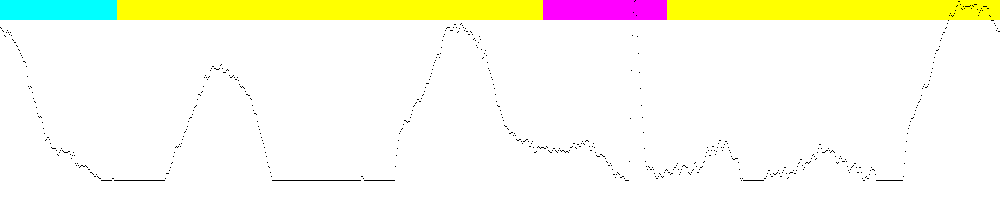

In [6]:
randompatient = np.random.randint(105, size=1)[0]
IPython.display.display(PIL.Image.fromarray(visualizecurve(allecgdata[randompatient][1],allecgdata[randompatient][2],None)))

On voit donc l'ECG et les 3 labels représentés par 3 couleurs au dessus.
*Bon j'admets que c'est pas très beau comme affichage mais...*

**Notre objectif est d'apprendre à un réseau à prédire ce label (à chaque instant) à partir de l'ECG. Lors de l'apprentissage le réseau utilise l'ECG et le label pour mettre à jours ses poids. En test, on n'utilise que l'ECG et on prédit un label (puis on compare avec le label réel pour voir si ça marche).**

Commençons par couper train/test aléatoirement :

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

X,Y = [],[]    
for i in range(allecgdata.shape[0]):
    X.append(allecgdata[i][0:2])
    Y.append(allecgdata[i][2].astype(int))

X,Y = shuffle(X,Y)

Xtest,Ytest = X[0:15],Y[0:15]
X,Y = X[15:],Y[15:]

Et introduisons notre fonction d'évaluation : on prend X, Y et un model et on compte le nombre de fois qu'on a prédit la bonne réponse - **accuracy** en anglais

In [0]:
def eval_model(X,Y,model):
    cm = np.zeros((3,3),dtype=int)
    Z = model(torch.Tensor(np.stack(X)))
    Z = Z.cpu().data.numpy()
    Z = np.argmax(Z,axis=1)
    for i in range(len(Y)):
        cm += confusion_matrix(Y[i], Z[i],list(range(3)))
    return (cm[0][0]+cm[1][1]+cm[2][2])/(np.sum(cm)+1),cm

Maintenant, définissons un réseau qui apprend à segmenter. Pour commencer on va mettre juste 2 couches avec 1 couche de pré traitement et une couche de pooling (ça va pas marcher mais c'est pour introduire le code).

In [0]:
class PetitNet(nn.Module):
    def __init__(self):
        super(PetitNet, self).__init__()
        self.bnm1 = nn.BatchNorm1d(2, momentum=0.1)
        self.fc0 = nn.Conv1d(2, 32, kernel_size=11, padding=5)
        self.fc11 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc12 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc13 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc14 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc15 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc16 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc17 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc18 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc19 = nn.Conv1d(32, 32, kernel_size=11, padding=5)
        self.fc1 = nn.Conv1d(32, 3, kernel_size=11, padding=5)

    def forward(self, x):
        
        x = F.leaky_relu(self.fc0(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)

        x = F.leaky_relu(self.fc11(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)
        x = F.leaky_relu(self.fc12(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)
        x = F.leaky_relu(self.fc13(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)
        x = F.leaky_relu(self.fc14(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)
        x = F.leaky_relu(self.fc15(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)
        x = F.leaky_relu(self.fc16(x))
        x = F.max_pool1d(x, kernel_size=5, stride=1, padding=2)

        x = self.fc1(x)
        return x

model = PetitNet()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
losslayer = nn.CrossEntropyLoss()
batchsize = 50

import collections
memoryofloss = collections.deque(maxlen=200)


Lancer le code d'apprentissage ci dessous - comme il devrait prendre 5 mins, vous pouvez chercher à comprendre ce qu'il fait pendant qu'il tourne

In [24]:
for iteration in range(5000):
    model.train()
    model.cuda()
    
    X,Y = shuffle(X,Y)
    Ybatch = np.stack(Y[0:batchsize])
    Z = model(torch.Tensor(np.stack(X[0:batchsize])).cuda())
        
    # move from BATCH x NB CLASSES x 8192 to 409600 x NB CLASSES
    Z = torch.transpose(Z,1,2)
    Z = Z.contiguous().view(409600,3)
    Ybatch = Ybatch.flatten()
    Ybatch = torch.from_numpy(Ybatch).long().cuda()
    
    loss = losslayer(Z,Ybatch)
    
    memoryofloss.append(loss.cpu().data.numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration%100==99:
        print(sum(memoryofloss)/len(memoryofloss))
        with torch.no_grad():
            model.eval()
            model.cpu()
            print(eval_model(Xtest,Ytest,model))
            print(eval_model(X,Y,model))
            torch.save(model,"model.ptz")

1.0732719111442566
(0.4043017228049902, array([[    0,    28, 42301],
       [    0,   468, 30870],
       [    0,     0, 49213]]))
(0.42988358576987606, array([[     0,   5308, 226289],
       [     0,  11998, 182118],
       [     0,   6620, 304947]]))


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type PetitNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1.0266095313429833
(0.5166054963745412, array([[ 2541,   379, 39409],
       [ 1096, 11980, 18262],
       [   12,   241, 48960]]))
(0.5569735284104703, array([[ 19592,   6332, 205673],
       [  9879,  97226,  87011],
       [  3462,  14277, 293828]]))
0.9183169382810593
(0.6566108674245815, array([[10938,   794, 30597],
       [ 1300, 21152,  8886],
       [  101,   517, 48595]]))
(0.6451841292532969, array([[ 62094,   9102, 160401],
       [  9963, 130342,  53811],
       [  8361,  19960, 283246]]))
0.8054304102063179
(0.7313417045759719, array([[27962,   971, 13396],
       [ 1317, 20705,  9316],
       [ 7476,   536, 41201]]))
(0.7235151862044458, array([[154590,  10773,  66234],
       [ 15267, 143390,  35459],
       [ 59445,  16668, 235454]]))
0.7191143706440926
(0.7440531896713081, array([[25170,  1216, 15943],
       [  874, 21834,  8630],
       [ 4073,   714, 44426]]))
(0.752586869863729, array([[138946,  11227,  81424],
       [ 12025, 153656,  28435],
       [ 30312,  189

KeyboardInterrupt: ignored

Le code correspond juste à faire une boucle, dans laquelle on prend un bloc de données (batch), on le fait passer dans le réseau (ça produit Z). Après, il y a un peu de truc bizarre pour remettre les variables dans le bon format, mais ce qui compte c'est qu'on calcule une loss entre Z les prédictions et Y ce qu'on veut.
Puis, on fait une descente de gradient.

Mais ici, ça ne marche pas : le réseau n'est pas assez expressif - il n'est ni bon sur la base d'apprentissage - ni sur celle de test (s'il était bon sur celle d'apprentissage mais pas de test, il n'y aurait pas beaucoup d'espoir - mais là si).

**Rajouter des couches (convolution et pooling) pour que ça marche mieux.**

Vous pouvez aussi rajouter des prétraitements pour homogénéiser les données (centrer les données, etc) à la main et/ou via des couches de normalisation.

Vous pouvez aussi aller jouer avec https://playground.tensorflow.org qui propose la même chose en plus jolie sur des données vectorielles (des points 2D, ici on a un signal temporel).

In [25]:
model = torch.load("model.ptz")
print(eval_model(Xtest,Ytest,model))

(0.7815284706341908, array([[38768,   821,  2740],
       [ 1939, 22011,  7388],
       [12569,  1388, 35256]]))


##Les réseaux récurrents

Passons maintenant aux réseaux récurrents.
En tant qu'utilisateur, utiliser un réseau récurrent consiste simplement à remplacer une partie des convolutions par un LSTM et/ou un GRU.

D'un point de vue théorique, cela permet de réduire le nombre de paramètre pour un horizon temporel donné. Et, à performance égales, il y a une prime à l'utilisation de LSTM pour publier.

Maintenant, *est ce que réduire le nombre de paramétre c'est mieux en pratique  ?*
Malheureusement, *p'têt ben qu'oui, p'têt ben qu'non*, le mieux c'est d'essayer.


In [0]:
class PetitNetRecurrent(nn.Module):
    def __init__(self):
        super(PetitNetRecurrent, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=128, num_layers=2)
        self.outputprob = nn.Conv1d(128, 3, kernel_size=1)

    def forward(self, x):
        xTBF = torch.transpose(x,1,2)
        xTBF = torch.transpose(xTBF,0,1)
        
        lstmoutput,_ = self.lstm(xTBF)
        xBFT = torch.transpose(lstmoutput,0,1)
        xBFT = torch.transpose(xBFT,1,2)

        x = self.outputprob(xBFT)
        return x

Vous remarquerez que le réseau a besoin d'opérations de transposition car le LSTM n'a pas le même format d'entrée qu'une convolution (trop facile sinon...) : la convolution attend des données Batch x Feature x Temps alors que le lstm attend des données Temps x Batch x Feature.

**faites le code d'apprentissage correspondant et tester ce mini réseau**

In [0]:
print("TODO")

Normalement, 1 seul LSTM ne devrait pas suffire, vous pouvez soit augmenter le nombre et la taille des couches cachées, soit combiner lstm et convolution.

In [0]:
print("TODO")